## Notebook to work with interaction dataset merge scenario `DR_CHN_Merging_ZS`
    - Roadway generation
    - Trajdata creation based on reading vehicle tracks from provided csv files

## Changelog
- Friday, Jan 31
    - Creation
    - Toy track generation using way if 10025 from `DR_CHN_Merging_ZS.osm`
- Monday, Feb 3
    - Begin trajdata creation to read in the vehicle tracks. Creation of struct called `INTERACTIONTrajdata`
- Tuesday, Feb 4
    - `Trajdata` reading nominally works. And rendered a scene of course without roadway. Some caveats
        - `car_df_index` line 21 onwards check is commented out
        - No `roadway` involved in the creation of `RecordState`
    - Made a video of replaying the trajdata, of course without roadway, just cars in the blackness
- Wednesday, Feb 5
    - roadway building using `generate_merging_roadway` from `AutonomousMerging.jl`
    - brought in `curevept_overlay` to do overlay the curve points that constitute a road
    - Drove a car in the merging scenario to check that lane semantics works i.e. vehicle understands
    how to keep lane
    - second roadway inspired by William Brannon curved merging lane
- Friday, Feb 7
    - Started pipeline to read Soyeon's centerline data files
    - Generated video replaying interaction dataset on roadways

In [39]:
# usings
using AutomotiveDrivingModels
using AutoViz

In [31]:
# function: append to curve
function append_to_curve!(target::Curve, newstuff::Curve)
    s_end = target[end].s
    for c in newstuff
        push!(target, CurvePt(c.pos, c.s+s_end, c.k, c.kd))
    end
    return target
end

append_to_curve! (generic function with 1 method)

In [30]:
# functions: angle calculation
"""
    function append_headings
- Used create the angles and append them into the coordinates

# Examples
```julia
x_coods = [1089.07510, 1093.82626, 1101.19325, 1112.59899, 1123.96733, 1133.24150, 1146.47964]
y_coods = [936.31213, 936.92692,938.52419, 940.93865, 943.27882, 945.21039, 947.88488]
coods = hcat(x_coods,y_coods)
append_headings(coods)
```
"""
function append_headings(coordinates::Matrix{Float64})
    headings = ones(size(coordinates)[1])
    for i = 1:size(coordinates)[1]-1
        # need to make sure that math is right, and that bounds are kept
        tangent_vector = [coordinates[i+1,1]-coordinates[i,1], coordinates[i+1,2]-coordinates[i,2]]
        # @show tangent_vector
        current_heading = get_new_angle(tangent_vector)
        # @show current_heading
        headings[i] = current_heading
    end
    headings[end] = headings[end-1] # assume this is fine
    coordinates = hcat(coordinates, headings)
    return coordinates
end

"""
    function get_new_angle
- Does the actual angle calculation based on the x y coordinates
"""
function get_new_angle(tangent_vector::Array{Float64})
    # it might be a problem when we switch quadrants
    # use signs of tangent vector to get the quadrant of the heading 
    x = tangent_vector[1]
    y = tangent_vector[2]
    if x == 0. && y == 0.
        heading = 0.0
    elseif x == 0.
        heading = π/2 * sign(y) 
    elseif y == 0.
        heading = convert(Float64, π) # this could be either pi or -pi, but just go with pi
    elseif sign(x) == 1 && sign(y) == 1 # first quadrant
        heading = atan(y, x)
    elseif sign(x) == -1 && sign(y) == 1 # second quadrant
        heading = atan(y, x)
    elseif sign(x) == 1 && sign(y) == -1 # fourth quadrant
        heading = atan(y, x)
    elseif sign(x) == -1 && sign(y) == -1 # third quadrant
        heading = atan(y, x)
    end
    # bound_heading doesn't end up getting called cause Julia takes care of it apparently
    bound_heading(heading)

    return heading
end

"""
    function bound_heading
- Make the angle range from 0 to pi instead of going beyond
"""
function bound_heading(heading::Float64)
    if heading > π # send this to be just near -pi
        heading = -π + (heading - π)    # if heading is 3.15, then the new angle will be (-pi + (3.15-pi)) = -3.13
    elseif heading < -π # send this to be just near pi 
        heading = π + (heading + π)     # if heading is -3.15, then the new angle will be (pi + (-3.15+pi)) = 3.13
    end
    return heading
end

bound_heading

In [ ]:
# function: get_track
"""
    function get_track()

- Generate a track based on x and y coordinates of the centerline
- Extracts angles as an intermediate step
"""
function get_track()
    # way 10025 for illustrate purposes
    x_coods = [1089.07510, 1093.82626, 1101.19325, 1112.59899, 1123.96733, 1133.24150, 1146.47964]
    y_coods = [936.31213, 936.92692,938.52419, 940.93865, 943.27882, 945.21039, 947.88488]

    coods = hcat(x_coods,y_coods)
    coods_app = append_headings(coods) # Append with the angle
    
    mid_coods = coods_app'
    
    first_cood = VecSE2(mid_coods[1,1], mid_coods[2,1], mid_coods[3,1])
    second_cood = VecSE2(mid_coods[1,2], mid_coods[2,2], mid_coods[3,2])
    radius = 0.01
    nsamples = 20

    track = gen_bezier_curve(first_cood, second_cood, radius, radius, nsamples)
    
    nsamples = 20
    for i = 3:7
        turn1 = VecSE2(mid_coods[1, i-1], mid_coods[2, i-1], mid_coods[3, i-1])
        turn2 = VecSE2(mid_coods[1, i], mid_coods[2, i], mid_coods[3, i])
        curve = gen_bezier_curve(turn1, turn2, radius, radius, nsamples)
        append_to_curve!(track, curve)
    end

    return track
end

In [ ]:
# script: generate the roadway

#nlanes = 1
#length = 50.

#roadway = gen_straight_roadway(nlanes, length)

width = DEFAULT_LANE_WIDTH
roadway = Roadway()

track = get_track()

lane = Lane(LaneTag(1, 2), track, width=DEFAULT_LANE_WIDTH)
push!(roadway.segments, RoadSegment(lane.tag.segment, [lane]))
cam = FitToContentCamera(0.05)
render(roadway, cam=cam)

In [ ]:
@show roadway.segments[1].lanes

## Interaction track experimentation

In [57]:
# usings: Specific to trajdata
using DataFrames
using Records
using Reel

┌ Info: Recompiling stale cache file /home/raunak/.julia/compiled/v1.1/DataFrames/AR9oZ.ji for DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1184


In [58]:
# constants: timestep
const INTERACTION_TIMESTEP = 0.1 # unit is second

0.1

In [59]:
# struct: the interaction trajdata
"""
INTERACTIONTrajdata
The trajectory data stored in the original INTERACTION dataset format.
The dataset is a csv file with columns:
    track_id      - Int64 - Representing the id of the agent
    frame_id      - Int64 - Represents the frames in which the agent appears in the video
    timestamp_ms  - Int64 - represents the time the agent appears in the video. The unit is millisecond
    agent_type    - String - Can be person, car, truck and so on
    x             - Float64 - x position, in meter
    y             - Float64 - y position in meter
    vx            - Float64 - x velocity in m/s
    vy            - Float64 - y velocity in m/s
    psi_rad       - Float64 - yaw angle in radian
    length        - Float64 - Length of the vehicle, in meter
    width         - Float64 - Width of the vehicle, in meter

# Example
```julia
tdraw = INTERACTIONTrajdata("vehicle_tracks_000.csv");
```
"""
mutable struct INTERACTIONTrajdata
    df         :: DataFrame
    car2start  :: Dict{Int, Int}         # maps carindex to starting index in the df
    frame2cars :: Dict{Int, Vector{Int}} # maps frame to list of carids in the scene

    function INTERACTIONTrajdata(input_path::String)

        @assert(isfile(input_path))

        df = readtable(input_path, separator=',', header = true)

        car2start = Dict{Int, Int}()
        frame2cars = Dict{Int, Vector{Int}}()

        for (dfind, carid) in enumerate(df[:track_id])
            if !haskey(car2start, carid)
                car2start[carid] = dfind
            end

            frame = convert(Int, df[dfind, :frame_id])
            if !haskey(frame2cars, frame)
                frame2cars[frame] = [carid]
            else
                frame2cars[frame] = push!(frame2cars[frame], carid)
            end
        end

        new(df, car2start, frame2cars)
    end
end

INTERACTIONTrajdata

In [60]:
# function: overload nframes from Records
"""
    Records.nframes

# Example
```julia
tdraw = INTERACTIONTrajdata("vehicle_tracks_000.csv")
nframes(tdraw)
```
"""
Records.nframes(trajdata::INTERACTIONTrajdata) = maximum(keys(trajdata.frame2cars))

Records.nframes

In [61]:
# function: carsinframe for memory allocation
"""
    carsinframe(trajdata::INTERACTIONTrajdata, frame::Int)
- From the dictionary `frame2cars` which has frame number as key and all vector of car ids in that frame
as value, this function extracts the value corresponding to key given by `frame`

# Example
```julia
# Return array with car ids in frame 1
carsinframe(tdraw,1)
```
"""
carsinframe(trajdata::INTERACTIONTrajdata, frame::Int) = get(trajdata.frame2cars, frame, Int[])

carsinframe

In [ ]:
# function: car_df_index - find index of car in trajdata
function car_df_index(trajdata::INTERACTIONTrajdata, carid::Int, frame::Int)
    #=
    given frame and carid, find index of car in trajdata
    Returns 0 if it does not exist
    =#

    df = trajdata.df

    lo = trajdata.car2start[carid] # The index in the dataframe where carid first appears
    framestart = df[lo, :frame_id] # The frame number where carid first appears
    print("car_df_index says framestart = $(framestart)\n")
    retval = 0

    if framestart == frame
        retval = lo
    elseif frame ≥ framestart
        print("car_df_index says frame >= framestart\n")
        print("car_df_index says lo = $(lo)")
        retval = frame - framestart + lo
        #n_frames = df[lo, :n_frames_in_dataset]
        #if retval > lo + n_frames
        #    retval = 0
        #end
    end

    retval
end

In [62]:
# script: read data from csv file into INTERACTIONTrajdata struct and prepare for next steps i.e.
# what Base.convert(::Type{Trajdata}, tdraw::NGSIMTrajdata, roadway::Roadway) does in NGSIM/trajdata.jl
tdraw = INTERACTIONTrajdata("vehicle_tracks_000.csv");
df = tdraw.df
vehdefs = Dict{Int, VehicleDef}()
states = Array{RecordState{VehicleState, Int}}(undef, nrow(df))
frames = Array{RecordFrame}(undef, nframes(tdraw));

┌ Warning: readtable is deprecated, use CSV.read from the CSV package instead
│   caller = ip:0x0
└ @ Core :-1


In [63]:
# script: initialize the vehicle definition in terms of type, length and width
for (id, dfind) in tdraw.car2start
    # CAUTION: Hardcoding vehicle type to be just car shown by the first argument being 2
    vehdefs[id] = VehicleDef(2, df[dfind, :length], df[dfind, :width])
    #if df[dfind,:agent_type] == "car"
    #    print("dfind is $(dfind)")
    #    print(df[dfind,:agent_type])
    #end
end

In [66]:
# script: loop over data and create the vehicle state sequence. NOTE: THIS NEEDS THE ROADWAY
state_ind = 0

for frame in 1 : nframes(tdraw)

    frame_lo = state_ind+1

    for id in carsinframe(tdraw, frame)

        dfind = car_df_index(tdraw, id, frame)


        posG = VecSE2(df[dfind, :x], df[dfind, :y], df[dfind, :psi_rad])
        vx = df[dfind,:vx]
        vy = df[dfind,:vy]
        speed = sqrt(vx*vx + vy*vy)

        #states[state_ind += 1] = RecordState(VehicleState(posG, roadway, speed), id)
        states[state_ind += 1] = RecordState(VehicleState(posG, speed), id)
    end

    frame_hi = state_ind
    frames[frame] = RecordFrame(frame_lo, frame_hi)
end
traj_interaction = Trajdata(INTERACTION_TIMESTEP, frames, states, vehdefs);

car_df_index says framestart = 1


BoundsError: BoundsError: attempt to access 1-element Array{Lane{Float64},1} at index [2]

## Video making helper functions

In [72]:
# overlays: IDOverlay, my_overlay, curve points overlay
"""
    IDOverlay
Display the ID on top of each entity in a scene.
# Fields
- `color::Colorant`
- `font_size::Int64`
"""
# mutable struct IDOverlay <: SceneOverlay
#     color::Colorant
#     font_size::Int
# end

# function AutoViz.render!(rendermodel::RenderModel, overlay::IDOverlay, scene::Scene, 
#                             env::E) where E
#     font_size = overlay.font_size
#     for veh in scene
#         add_instruction!(rendermodel, render_text, ("$(veh.id)", veh.state.posG.x, 
#                         veh.state.posG.y, font_size, overlay.color), incameraframe=true)
#     end
#     return rendermodel
# end

"""
    my_overlay
Overlaying hallucinated trajectory on the ground truth
# Fields
- `color::Colorant`
- `scene::Scene`
"""
struct my_overlay <: SceneOverlay
    scene::Scene
    color # Needs to be of form colorant"Colorname"
end

function AutoViz.render!(rendermodel::RenderModel,overlay::my_overlay, 
        scene::Scene, roadway::Roadway)
    AutoViz.render!(rendermodel,overlay.scene,car_color = overlay.color)
    return rendermodel
end

"""
    curve_pts_overlay
Displays a circle on one of the top corner of a vehicle to symbolize a blinker. 
fields: 
- color: the color of the blinker
- size: the size of the blinker 
""" 
struct curvepts_overlay <: SceneOverlay
    roadway
    color::Colorant # yellow 
    size::Float64
end

function AutoViz.render!(rendermodel::RenderModel, overlay::curvepts_overlay, 
        scene::Frame{Entity{S,D,I}}, roadway::R) where {S,D,I,R}
    
    
    num_segments = length(roadway.segments)
    
    # Loop over segments
    for seg_i in 1:num_segments
        seg = roadway.segments[seg_i]
        num_lanes = length(seg.lanes)
        
        # Within a segment, loop over lanes
        for lane_i in 1:num_lanes
            lane = seg.lanes[lane_i]
            
            # Within a lane, loop over the curve points
            num_curvepts = length(lane.curve)
            for cpt_i in 1:num_curvepts
                cpt = lane.curve[cpt_i]
                
                add_instruction!(rendermodel,render_circle,
                    (cpt.pos.x,cpt.pos.y,overlay.size,overlay.color))
            end
        end
    end
    
end

In [73]:
# function: get scene from trajdata
"""
    function get_scene(framenum::Int64,traj)

Get a specific scene from trajdata

# Example:
```julia
scene = get_scene(1,int_trajdata)
```
"""
function get_scene(framenum::Int64,traj=traj_interaction)
    scene = Scene(500)
    get!(scene,traj,framenum)
    return scene
end

get_scene

In [76]:
# function: replay traj_data video
"""
    function video_trajdata_replay(;range=nothing,filename="trajdata_$(range).mp4")

Makes a video of the trajdata without a roadway taking frame range as input

# Example
```julia
video_trajdata_replay(range=1:100,traj=traj_interaction)
```
"""
function video_trajdata_replay(id_list = [];range=nothing,traj=traj_interaction,
        filename="media/interaction_vids/$(range).mp4")

    frames = Frames(MIME("image/png"), fps=10)
    scene = Scene(500)
    for i in range
        temp_scene = get_scene(i,traj)
        if !isempty(id_list) keep_vehicle_subset!(temp_scene,id_list) end
        
        scene_visual = render(temp_scene, 
            roadway,
            #[IDOverlay(colorant"white",12),TextOverlay(text=["frame=$(i)"],font_size=12)],
            #cam=SceneFollowCamera(10.),
            cam=FitToContentCamera(0.),
            #canvas_width = 2250,
        )
        push!(frames,scene_visual)
    end
    write(filename,frames)
    print("Making interaction replay video called $filename")
    
    return nothing
end

video_trajdata_replay

In [77]:
video_trajdata_replay(range=1:100,filename="media/interaction_vids/vid_$(range).mp4")

Making interaction replay video called media/interaction_vids/vid_range.mp4

In [ ]:
# function: make a video from a list of scenes
"""
    function scenelist2video(scene_list;filename = "media/mobil/scene_to_video.mp4")
- Make video from a list of scenes

# Examples
```julia
scene_list = get_hallucination_scenes(scene2,models=models,traj=int_trajdata,roadway=roadway2)
scenelist2video(scene_list,roadway=roadway2,filename="media/interaction_vids/merge.mp4")
```
"""
function scenelist2video(scene_list;id_list=[],
        filename = "media/mobil/scene_to_video.mp4",roadway=roadway_ngsim)
    frames = Frames(MIME("image/png"),fps = 10)
    
    # Loop over list of scenes and convert to video
    for i in 1:length(scene_list)
        if !isempty(id_list) keep_vehicle_subset!(scene_list[i],id_list) end
        scene_visual = render(scene_list[i],roadway,
        [IDOverlay(colorant"white",12)],
        cam=FitToContentCamera(0.),
        #cam = SceneFollowCamera(10.)
        )
        push!(frames,scene_visual)
    end
    print("Making video filename: $(filename)\n")
    write(filename,frames)
    return nothing
end

## Points of information eg: Base.read definition

In [ ]:
# point of information: used to read trajdata information from text file
# uses Base.read overload defined in Records.jl/src/listrecords.jl
traj_ngsim = open(io->read(io, MIME"text/plain"(), Trajdata), 
    "trajdata_i101_trajectories-0750am-0805am.txt", "r");

## Maxime roadway: Adapted from AutonomousMerging.jl

In [ ]:
using Parameters

In [ ]:
# struct and functions: generation of merging roadway
const MAIN_LANE_ID = 1
const MERGE_LANE_ID = 2

"""
    MergingEnvironment
A road network with a main lane and a merging lane. The geometry can be modified by 
passing the parameters as keyword arguments in the constructor
# Parameters
- `lane_width::Float64 = 3.0`
- `main_lane_vmax::Float64 = 15.0`
- `merge_lane_vmax::Float64 = 10.0`
- `main_lane_length::Float64 = 100.0`
- `main_lane_angle::Float64 = float(pi)/4`
- `merge_lane_angle::Float64 = float(pi)/4`
- `merge_lane_length::Float64 = 50.0`
- `after_merge_length::Float64 = 50.0`
# Internals 
- `roadway::Roadway{Float64}` contains all the road segment and lane information
- `merge_point::VecSE2{Float64}` coordinate of the merge point in cartesian frame (0.0, 0.0, 0.0) by default
- `merge_proj::RoadProjection{Int64, Float64}` projection of the merge point on the roadway 
- `merge_index::RoadIndex`
"""
@with_kw struct MergingEnvironment
    lane_width::Float64 = 3.0
    main_lane_vmax::Float64 = 15.0
    merge_lane_vmax::Float64 = 10.0
    main_lane_length::Float64 = 100.0
    main_lane_angle::Float64 = float(pi)/4
    merge_lane_angle::Float64 = float(pi)/4
    merge_lane_length::Float64 = 50.0
    after_merge_length::Float64 = 50.0

    # internals
    roadway::Roadway{Float64} = generate_merging_roadway(lane_width, 
                                                main_lane_vmax, 
                                                merge_lane_vmax, 
                                                main_lane_length,
                                                merge_lane_length,
                                                after_merge_length, 
                                                main_lane_angle, 
                                                merge_lane_angle) 
    merge_point::VecSE2{Float64} = VecSE2(0.0, 0.0, 0.0)
    merge_proj::RoadProjection{Int64, Float64} = proj(merge_point, roadway)
    merge_index::RoadIndex{Int64, Float64} = RoadIndex(merge_proj.curveproj.ind, merge_proj.tag)
end


function append_to_curve!(target::Curve{T}, newstuff::Curve{T}) where T <: Real
    s_end = target[end].s
    for c in newstuff
        push!(target, CurvePt{T}(c.pos, c.s+s_end, c.k, c.kd))
    end
    return target
end

"""
    generate_merging_roadway(lane_width::Float64 = 3.0, main_lane_vmax::Float64 = 20.0, 
merge_lane_vmax::Float64 = 15.0, main_lane_length::Float64 = 20.0, 
merge_lane_length::Float64 = 20.0, after_merge_length::Float64 = 20.0, 
main_lane_angle::Float64 = float(pi)/4, merge_lane_angle::Float64 = float(pi)/4)
Generate a `Roadway` object representing a merging scenario. 
The merge point is defined at (0., 0.) by default.
"""
function generate_merging_roadway(lane_width::Float64 = 3.0, 
                                   main_lane_vmax::Float64 = 20.0,
                                   merge_lane_vmax::Float64 = 15.0,
                                   main_lane_length::Float64 = 20.0, 
                                   merge_lane_length::Float64 = 20.0,
                                   after_merge_length::Float64 = 20.0,
                                   main_lane_angle::Float64 = float(pi)/4, 
                                   merge_lane_angle::Float64 = float(pi)/4) 
    # init empty roadway 
    roadway = Roadway()
    n_pts = 2 # sample points for the roadway, only two needed each time, since all segments are straight
    main_tag = LaneTag(MAIN_LANE_ID, 1)
    merge_tag = LaneTag(MERGE_LANE_ID, 1)
    # after_merge_tag = LaneTag(AFTER_MERGE_LANE_ID, 1)

    # define curves
    merge_point = VecE2(0.0, 0.0) 
    main_lane_startpt = merge_point + polar(main_lane_length, -float(pi) - main_lane_angle)
    main_curve = gen_straight_curve(main_lane_startpt, merge_point, n_pts)
    merge_index = curveindex_end(main_curve)
    append_to_curve!(main_curve, 
        gen_straight_curve(merge_point, merge_point + polar(after_merge_length, 0.0), n_pts)[2:end])
    merge_lane_startpt = merge_point + polar(merge_lane_length, float(pi) + merge_lane_angle)
    merge_curve = gen_straight_curve(merge_lane_startpt, merge_point, n_pts)


    # define lanes with connections 
    main_lane = Lane(main_tag, main_curve, width = lane_width, speed_limit=SpeedLimit(0.,main_lane_vmax))
    merge_lane = Lane(merge_tag, merge_curve, width = lane_width,speed_limit=SpeedLimit(0.,merge_lane_vmax),
                        next=RoadIndex(merge_index, main_tag))

    # add segments to roadway 
    push!(roadway.segments, RoadSegment(MAIN_LANE_ID, [main_lane]))
    push!(roadway.segments, RoadSegment(MERGE_LANE_ID, [merge_lane]))
  
    return roadway
end

In [ ]:
polar(20,-float(pi))

In [ ]:
polar(20,float(pi)+float(pi)/4)

In [ ]:
scene = Scene()
state1 = VehicleState(Frenet(roadway[LaneTag(1,1)],3.0), roadway, 10.0)
veh1 = Vehicle(state1, VehicleDef(), 1)

push!(scene, veh1)

In [ ]:
cpt_o = curvepts_overlay(roadway,colorant"0xFFEF00",0.3)
render(scene,roadway,[cpt_o],cam=FitToContentCamera(0.2))

In [ ]:
# models creation: 2d driver model for the merging roadway
models = Dict{Int64,DriverModel}()
for veh in scene2
    models[veh.id] = Tim2DDriver(0.1,mlane=MOBIL(INTERACTION_TIMESTEP,mlon=IntelligentDriverModel()))
end

In [ ]:
# roadway creation: make a merging roadway
roadway2 = generate_merging_roadway(3.,20.,15.,40.,40.,40.,0.,-float(0.1));
cpt_o = curvepts_overlay(roadway2,colorant"0xFFEF00",0.3)
scene2 = Scene()
state2 = VehicleState(Frenet(roadway2[LaneTag(1,1)],13.0), roadway2, 10.0)
veh1 = Vehicle(state2, VehicleDef(), 1)

state3 = VehicleState(Frenet(roadway2[LaneTag(2,1)],5.0),roadway2,10.0)
veh2 = Vehicle(state3,VehicleDef(),2)
push!(scene2, veh1)
push!(scene2,veh2)
render(scene2,roadway2,[cpt_o],cam=FitToContentCamera(0.2))

In [ ]:
# function: get hallucination scenes
"""
    function get_hallucination_scenes
- Hallucinate starting from `start_step` for `nsteps` using `models` and return a list of scenes
- Used by `plot_carwise_pos_vel` to assess position and velocity traces against ground truth

# Returns
- `halluc_scenes_list`: List containing the scenes starting with the ground truth scene at `start_step`

# Examples
```julia
scene_list = get_hallucination_scenes(start_scene,nsteps=100,models=models);
```
"""
function get_hallucination_scenes(scene_halluc;models,start_step=1,duration=3,id_list=[],
        traj=traj_interaction,verbosity = false,timestep=INTERACTION_TIMESTEP,roadway=roadway_interaction)
        # Setting up
    halluc_scenes_list = []
    #scene_halluc = get_scene(start_step,traj) # Frame to start hallucination from
    push!(halluc_scenes_list,deepcopy(scene_halluc))
    
    nsteps = duration/timestep
    for (i,t) in enumerate(start_step:start_step+nsteps-1)
        
        if !isempty(id_list) keep_vehicle_subset!(scene_halluc,id_list) end
        
        actions = Array{Any}(undef,length(scene_halluc))

            # Propagation of scene forward
        get_actions!(actions,scene_halluc,roadway,models)

        tick!(scene_halluc,roadway,actions,timestep)
        
        push!(halluc_scenes_list,deepcopy(scene_halluc))
    end 
    return halluc_scenes_list
end

In [ ]:
scene_list = get_hallucination_scenes(scene2,models=models,traj=int_trajdata,roadway=roadway2)

In [ ]:
scenelist2video(scene_list,roadway=roadway2,filename="media/interaction_vids/merge.mp4")

## WB roadway

In [ ]:
# WBs example code for roadway generation: function and then script
function get_track_wb()

    x_coods = [0., 20.]
    y_coods = [3., 3.]
    theta = [0., 0.]
    
    turn_length = 10
    new_theta = 0.
    incremental_angle = (pi/4) / turn_length
    radius = 1
    for i = 1:turn_length
        push!(theta, new_theta)
        push!(x_coods, x_coods[end] + radius * cos(new_theta))
        push!(y_coods, y_coods[end] + radius * sin(new_theta))
        new_theta -= (incremental_angle)
    end

    # x coods in first row, y coods in second row, theta in third row
    mid_coods = vcat(x_coods', y_coods', theta') 
    
    
    first_cood = VecSE2(mid_coods[1,1], mid_coods[2,1], mid_coods[3,1])
    second_cood = VecSE2(mid_coods[1,2], mid_coods[2,2], mid_coods[3,2])
    radius = 0.01
    nsamples = 20

    track = gen_bezier_curve(first_cood, second_cood, radius, radius, nsamples)
    
    curve_radius = incremental_angle
    nsamples = 1000
    for i = 3:turn_length+2
        turn1 = VecSE2(mid_coods[1, i-1], mid_coods[2, i-1], mid_coods[3, i-1])
        turn2 = VecSE2(mid_coods[1, i], mid_coods[2, i], mid_coods[3, i])
        curve = gen_bezier_curve(turn1, turn2, curve_radius, curve_radius, nsamples)
        append_to_curve!(track, curve)
    end

    return track
end

# script: generate WB's roadway
nlanes = 1


roadway_wb = gen_straight_roadway(nlanes, 50.)

#width = DEFAULT_LANE_WIDTH
#roadway = Roadway()

track_wb = get_track_wb()

lane = Lane(LaneTag(2, 1), track_wb, width=DEFAULT_LANE_WIDTH)
push!(roadway_wb.segments, RoadSegment(2, [lane]))
cam = FitToContentCamera(0.05)
render(roadway_wb, cam=cam)

In [ ]:
cpt_o_wb = curvepts_overlay(roadway_wb,colorant"0xFFEF00",0.3)
scene_wb = Scene()
state_wb = VehicleState(Frenet(roadway_wb[LaneTag(1,1)],13.0), roadway_wb, 10.0)
veh1 = Vehicle(state_wb, VehicleDef(), 1)
l2 = roadway_wb.segments[2].lanes[1]
state_wb2 = VehicleState(Frenet(roadway_wb[LaneTag(2,1)],5.0),roadway_wb,10.0)
@show "here2"
veh2 = Vehicle(state_wb2,VehicleDef(),2)
push!(scene_wb, veh1)
push!(scene_wb,veh2)
render(scene_wb,roadway_wb,[cpt_o_wb],cam=FitToContentCamera(0.2))

In [ ]:
scene_list_wb = get_hallucination_scenes(scene_wb,duration=5,models=models,traj=int_trajdata,roadway=roadway_wb)
scenelist2video(scene_list_wb,roadway=roadway_wb,filename="media/interaction_vids/merge_wb.mp4")

## centerlines_DR_Merging_CHN_ZS a.k.a Soyeon roadways

In [8]:
using DelimitedFiles

In [53]:
#function: centerlines_txt2coords
"""
    function centerlines_txt2coords(filename)

- Input: text file with centerline coordinates with x in row 1 and y in row2
- Output: An array with x in col1 and y in col2. This is used by `coords2track`
- Requires: `using DelimitedFiles`
# Example
```julia
test_coods = centerlines_txt2coords("centerlines_DR_CHN_Merging_ZS/output_centerline_0.txt")
```
"""
function centerlines_txt2coords(filename)
    centerlines = readdlm(filename,',')
    x0 = centerlines[1,:]
    y0 = centerlines[2,:]
    coods = hcat(x0,y0)
    return coods
end

centerlines_txt2coords

In [27]:
# function: coords2track
"""
    function coords2track()

- Input: Centerline provided as 2 column array `coods` with x in col1 and y in col2
- Extracts angles as an intermediate step
- Output: track that can then be used to create a lane
"""
function coords2track(coods)
    coods_app = append_headings(coods) # Append with the angle
    
    mid_coods = coods_app'
    
    first_cood = VecSE2(mid_coods[1,1], mid_coods[2,1], mid_coods[3,1])
    second_cood = VecSE2(mid_coods[1,2], mid_coods[2,2], mid_coods[3,2])
    radius = 0.01
    nsamples = 20

    track = gen_bezier_curve(first_cood, second_cood, radius, radius, nsamples)
    
    nsamples = 20
    for i = 3:size(coods,1)
        turn1 = VecSE2(mid_coods[1, i-1], mid_coods[2, i-1], mid_coods[3, i-1])
        turn2 = VecSE2(mid_coods[1, i], mid_coods[2, i], mid_coods[3, i])
        curve = gen_bezier_curve(turn1, turn2, radius, radius, nsamples)
        append_to_curve!(track, curve)
    end

    return track
end

coords2track

In [55]:
track0 = coords2track(centerlines_txt2coords("centerlines_DR_CHN_Merging_ZS/output_centerline_0.txt"));
track1 = coords2track(centerlines_txt2coords("centerlines_DR_CHN_Merging_ZS/output_centerline_1.txt"))
track2 = coords2track(centerlines_txt2coords("centerlines_DR_CHN_Merging_ZS/output_centerline_2.txt"))
track3 = coords2track(centerlines_txt2coords("centerlines_DR_CHN_Merging_ZS/output_centerline_3.txt"))
track4 = coords2track(centerlines_txt2coords("centerlines_DR_CHN_Merging_ZS/output_centerline_4.txt"))
track5 = coords2track(centerlines_txt2coords("centerlines_DR_CHN_Merging_ZS/output_centerline_5.txt"))
track6 = coords2track(centerlines_txt2coords("centerlines_DR_CHN_Merging_ZS/output_centerline_6.txt"));

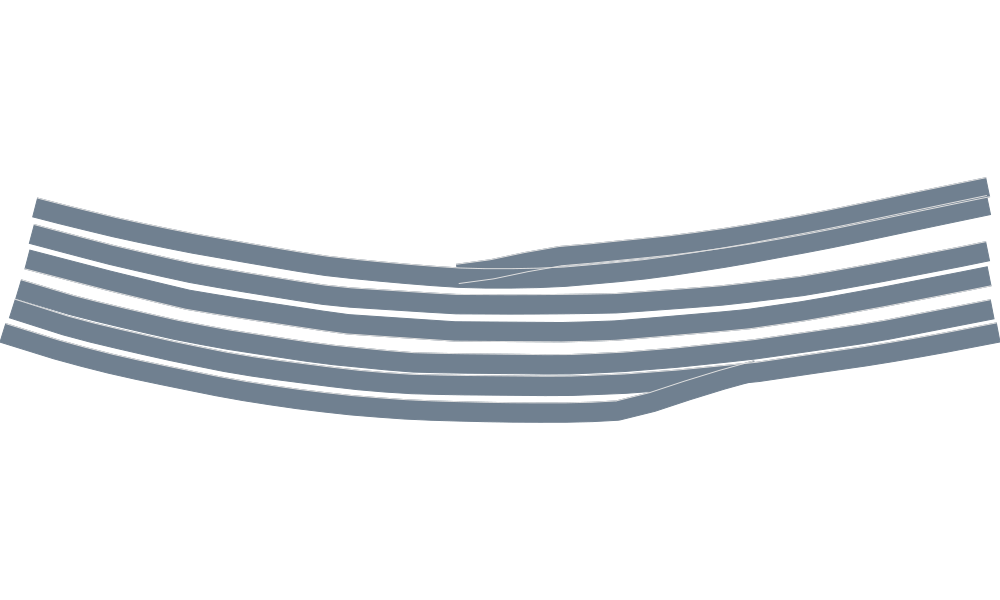

In [56]:
roadway = Roadway()
lane0 = Lane(LaneTag(1,1),track0)
lane1 = Lane(LaneTag(1,2),track1)
lane2 = Lane(LaneTag(1,3),track2)
lane3 = Lane(LaneTag(1,4),track3)
lane4 = Lane(LaneTag(1,5),track4)
lane5 = Lane(LaneTag(1,6),track5)
lane6 = Lane(LaneTag(1,7),track6)
push!(roadway.segments, RoadSegment(1, [lane0]))
push!(roadway.segments, RoadSegment(1, [lane1]))
push!(roadway.segments, RoadSegment(1, [lane2]))
push!(roadway.segments, RoadSegment(1, [lane3]))
push!(roadway.segments, RoadSegment(1, [lane4]))
push!(roadway.segments, RoadSegment(1, [lane5]))
push!(roadway.segments, RoadSegment(1, [lane6]))

render(roadway, cam=FitToContentCamera(0.))

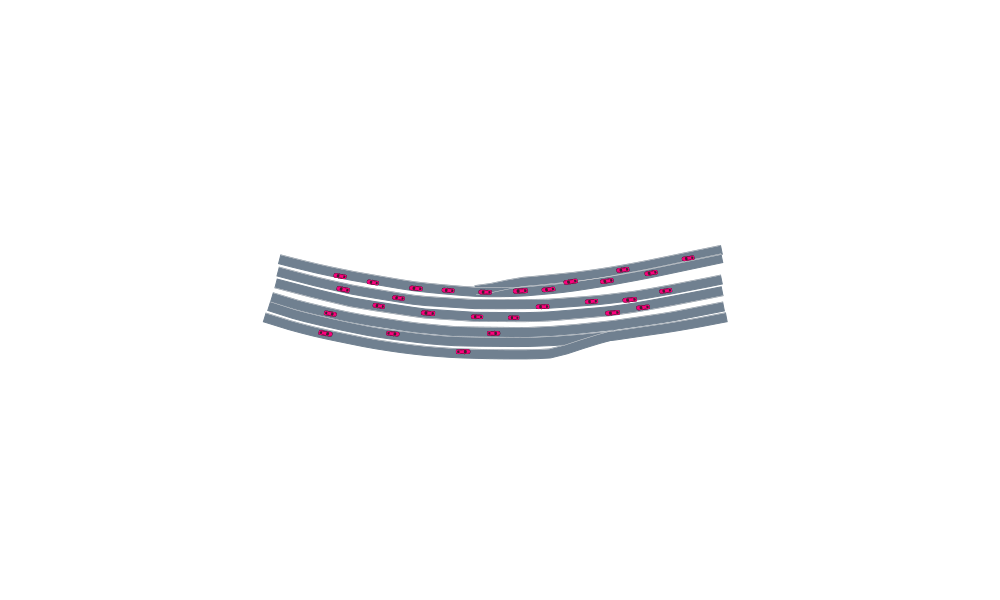

In [67]:
scene = Scene(500)
get!(scene,traj_interaction,1)
render(scene,roadway)